In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
wine_quality <- read_csv(file = "/home/jovyan/dsci-project/DSCI-Project/winequalityN.csv", show_col_types = FALSE)

names(wine_quality) <- make.names(colnames(wine_quality))

white_quality <- filter(wine_quality, type == "white") |>
                select(volatile.acidity, chlorides, total.sulfur.dioxide, quality) |>
                na.omit(volatile.acidity, chlorides, total.sulfur.dioxide, quality)
white_quality$volatile.acidity <- as.numeric(white_quality$volatile.acidity)
white_quality$chlorides<-as.numeric(white_quality$chlorides)
white_quality$total.sulfur.dioxide<-as.numeric(white_quality$total.sulfur.dioxide)
white_quality$quality<-as.factor(white_quality$quality)

In [3]:
set.seed(135)
wine_split <- initial_split(white_quality, prop = 0.75, strata = quality)
wine_train <- training (wine_split)
wine_test <- testing(wine_split)

In [4]:
#summarize with training data

In [5]:
wine_table <- wine_train|>
    group_by(quality)|>           
    summarize(mean.vol = mean(volatile.acidity), mean.chlor = mean(chlorides), 
              mean.sulf = mean(total.sulfur.dioxide))

wine_table

quality,mean.vol,mean.chlor,mean.sulf
<fct>,<dbl>,<dbl>,<dbl>
3,0.3396429,0.05921429,149.8929
4,0.3919531,0.05100000,123.5430
5,0.3035380,0.05157745,152.1916
6,0.2603785,0.04498168,136.4670
7,0.2631791,0.03832777,124.5584
8,0.2823864,0.03908333,129.3598
9,0.3075000,0.02625000,116.7500


In [6]:
#vfold

In [7]:
wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

In [8]:
#recipe

In [9]:
wine_recipe <- recipe(quality ~ volatile.acidity + chlorides + total.sulfur.dioxide , data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [10]:
#k-nearest neighbor

In [11]:
set.seed(2020)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

wine_fit <- workflow() |>
       add_recipe(wine_recipe) |>
       add_model(knn_spec) |>
       tune_grid(resamples = wine_vfold, grid = 10) |>
       collect_metrics()

! Fold2: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.



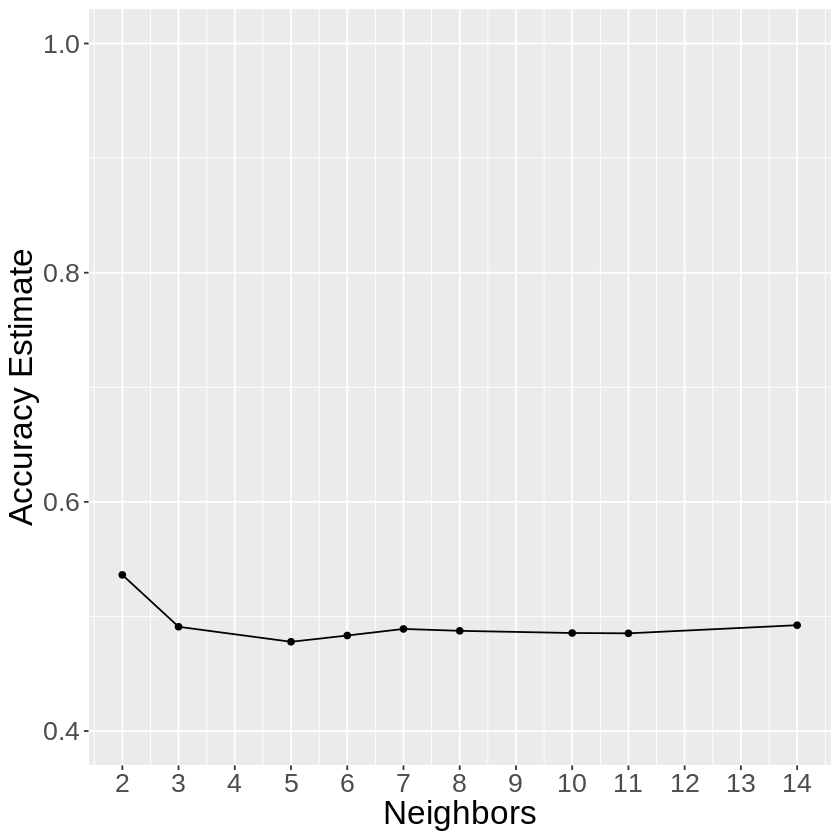

In [12]:
accuracies <- wine_fit |>
              filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Neighbors", y = "Accuracy Estimate") +
                     theme(text = element_text(size = 20)) +
                     scale_x_continuous(breaks = seq(0, 14, by = 1)) +
                     scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k

In [13]:
#choose k value

In [14]:
set.seed(9999) 

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
       set_engine("kknn") |>
       set_mode("classification")

wine_fit <- workflow() |>
             add_recipe(wine_recipe) |>
             add_model(wine_spec) |>
            fit(data = wine_train)
wine_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5030005
Best kernel: rectangular
Best k: 2

In [15]:
set.seed(9999) 


wine_predictions <- predict(wine_fit, wine_test) |>
                        bind_cols(wine_test)

wine_metrics <- wine_predictions |> metrics(truth = quality, estimate = .pred_class)
wine_conf_mat <- wine_predictions |>
                        conf_mat(truth = quality, estimate = .pred_class) 
wine_metrics
wine_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5519215
kap,multiclass,0.3276883


          Truth
Prediction   3   4   5   6   7   8   9
         3   1   1   1   1   0   0   0
         4   1   6  10   9   4   1   0
         5   1   8 204 125  30   5   0
         6   3  16 114 340  72  18   0
         7   0   3  30  68 110   5   1
         8   0   0   5  12   3  14   0
         9   0   0   0   1   0   0   0